In [27]:
import pylab
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform

from gw_eccentricity import load_waveform, load_data, get_available_methods, measure_eccentricity
from gw_eccentricity.load_data import get_available_waveform_origins, get_load_waveform_defaults, get_load_waveform_docs

from gw_eccentricity.plot_settings import use_fancy_plotsettings, labelsDict
from pycbc.waveform.waveform_modes import get_td_waveform_modes
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm#

#from matplotlib import rcParams
#rcParams.update({'figure.autolayout': True})
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 200
#plt.rcParams["font.family"] = "monospace"
 
from matplotlib import gridspec
from matplotlib import ticker

import matplotlib.pyplot as plt
#plt.style.reload_library()
#plt.style.use(['science','notebook'])



#pylab.rc('xtick', labelsize=18) 
#pylab.rc('ytick', labelsize=18) 
#pylab.rc('axes', labelsize=16)
#pylab.rc('legend', fontsize=15)


0.21049312028261025


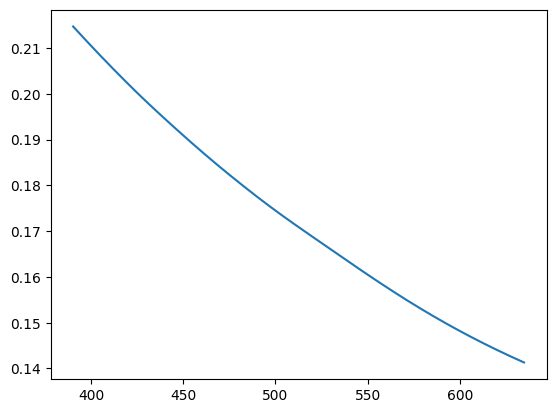

In [28]:
q=1/0.82
#ecc= [0.0091,0.013,0.029,0.038,0.070,0.13]
ecc = [0.13]
#m_omega=[0.020322,0.021330,0.018717,0.19363,0.018392,0.017351]
m_omega = [0.017351]
for i in range(len(ecc)):
    kwargs = {
            "approximant": "EccentricTD",
            "q": q,
            "ecc": ecc[i],
            "chi1": [0.0,0.0,0.0],
            "chi2": [0.0,0.0,0.0],
            "mean_ano": 0.0,
            "Momega0": m_omega[i],
            "physicalUnits":True,
            "M":30,
            "D":1,
            "include_zero_ecc":True
            }
    origin = "LAL"
    dataDict = load_waveform(origin, **kwargs)
    method = "ResidualAmplitude"
    Time = dataDict["t"]
    return_dict = measure_eccentricity(fref_in = 55, method=method, dataDict = dataDict)
    gwecc_object= return_dict["gwecc_object"]

    Time_data=gwecc_object.get_omega22_average()[0]
    Omega_avg = gwecc_object.get_omega22_average()[1] 
    return_dict = measure_eccentricity(tref_in = Time_data, method=method, dataDict = dataDict)
    ecc=return_dict["eccentricity"]
    plt.plot(Omega_avg/2*PI,ecc)
    Ecc_intrp = interp1d(Omega_avg/2*PI,ecc,kind='cubic',fill_value='extrapolate')
    print(Ecc_intrp(400))
    #plt.xlim(450,700)

# PN Hybrid comparison

In [29]:
# Eq. (4.17a, 4.17b), Pg. 18, Moore et al (2016)

def epsilon(xi, eta):
    return(( 1 + ( ( -2833/2016 + 197/72 * eta ) * ( xi )**( 2/3 ) + 
                  ( -377/144 * np.pi * xi + ( ( 77006005/24385536 + ( -1143767/145152 * eta + 
 	 43807/10368 * ( eta )**( 2 ) ) ) * ( xi )**( 4/3 ) + ( np.pi * ( 9901567/1451520 + 
 	 -202589/362880 * eta ) * ( xi )**( 5/3 ) + ( xi )**( 2 ) * ( -33320661414619/386266890240 + 
 	 ( 3317/252 * EulerGamma + ( 180721/41472 * ( np.pi )**( 2 ) + ( ( 161339510737/8778792960 + 
 	 3977/2304 * ( np.pi )**( 2 ) ) * eta + ( -359037739/20901888 * ( eta )**( 2 ) + 
      ( 10647791/2239488 * ( eta )**( 3 ) + ( -87419/3780 * np.log( 2 ) + 
 	 ( 26001/1120 * np.log( 3 ) + 3317/504 * np.log( 16 * ( xi )**( 2/3 ) ) ) ) ) ) ) ) ) ) ) ) ) ) ))

In [30]:
# "Hinder+ modified all 20 simulations SEOBNRv4 model, full frequency range --Feb 16
g=open('tshift_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
A=[] 
for x in lines: 
    A.append(float(x.split()[1])) 
g.close()

def tshift_Hinsp(q,e,l): 
    return A[0] + A[1]*q + A[2]*q**2 + A[3]*e + A[4]*e**2 + A[5]*e**3 + A[6]*e*q + A[7]*(e**2)*q + A[8]*e*(q**2) + A[9]*(e**2)*(q**2) + A[10]*(e**3)*q + A[11]*e*q*math.cos(l + A[12]) + A[13]*(e**2)*(q**2)*math.cos(e*l + A[14]) + A[15]*(e**3)*q*math.cos(l + A[16]) + A[17]*e*(q**2)*math.cos(l + A[18])

g=open('tamp_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
B=[] 
for x in lines: 
    B.append(float(x.split()[1])) 
g.close()

def tamp_Hinsp(eta,e,l): 
    return B[0] + B[1]*eta + B[2]*eta**2 + B[3]*e + B[4]*e**2 + B[5]*e**3 + B[6]*e*eta + B[7]*(e**2)*eta + B[8]*e*(eta**2) + B[9]*(e**2)*(eta**2) + B[10]*(e**3)*eta + B[11]*e*eta*math.cos(l + B[12]) + B[13]*(e**2)*(eta**2)*math.cos(l + B[14]) + B[15]*(e**3)*eta*math.cos(e*l + B[16])

g=open('tfreq_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
C=[] 
for x in lines: 
    C.append(float(x.split()[1])) 
g.close()

def tfreq_Hinsp(eta,e,l): 
    return C[0] + C[1]*eta + C[2]*eta**2 + C[3]*e + C[4]*e**2 + C[5]*e**3 + C[6]*e*eta + C[7]*(e**2)*eta + C[8]*e*(eta**2) + C[9]*(e**2)*(eta**2) + C[10]*(e**3)*eta + C[11]*e*eta*math.cos(l + C[12]) + C[13]*(e**2)*(eta**2)*math.cos(l + C[14]) + C[15]*(e**3)*eta*math.cos(e*l + C[16])+ C[17]*(e**3)*(eta**2)*math.cos(e*l + C[18])

In [31]:
def xi(x):
    return x**(3/2)

def xconv(f,M):
    return (PI*M*MTSUN_SI*f)**(2/3)  #22 mode conversion

def fconv(x,M):
    return x**(3/2)/(PI*M*MTSUN_SI)  #22 mode conversion


In [32]:
def INSP_Eber22(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=0.045
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": e0,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": 0.045**(3/2),
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode2polfac=(5/(64*np.pi))**(1/2)   
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp22 = np.real(dataDict2["hlm"][(2,2)])
    hc22 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp22-1j*hc22)*2)/2
    
    return_dict1 = measure_eccentricity(tref_in=Time_data1,method=method,dataDict=dataDict2)
    gwecc_object = return_dict1["gwecc_object"]
    
    Time_data = gwecc_object.get_omega22_average()[0] 
    Omega_avg = gwecc_object.get_omega22_average()[1]
    
    Omega_avg_intrp = interp1d(Time_data, Omega_avg, kind='cubic', fill_value = 'extrapolate')
    Omega_avg = Omega_avg_intrp(Time_data1)
    del_t=np.abs(np.mean((np.diff(Time_data1))))
    

    
    omega3 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

       
    Fvec = Omega_avg/(2*PI) #Average frequency array

    Fvec=Fvec*(M0*MTSUN_SI)
    
    return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
    Eccentricity_new = return_dict1["eccentricity"]
    Eccentricity_new_intrp = interp1d(Time_data, Eccentricity_new, kind='cubic', fill_value = 'extrapolate')
    Eccentricity_new = Eccentricity_new_intrp(Time_data1)
    Mean_anomaly = return_dict1["mean_anomaly"]
    Mean_anomaly_intrp = interp1d(Time_data, Mean_anomaly, kind='cubic', fill_value = 'extrapolate')
    Mean_anomaly = Mean_anomaly_intrp(Time_data1)
    

    xiVec=(np.pi*M*Fvec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xVec = xVec


    lp=2
    mp=2
    
    j=0
    h22=[]
    h2_2=[]
    for i in tqdm(xVec):    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=Mean_anomaly[j]
        e=Eccentricity_new[j]
        psi= phs[j] #phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_22(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
 
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h22.append(hlm) 
        h2_2.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph22, sph2_2 = sph_harmonics(incl,lp)
    
    h = np.multiply(h22,1) #+np.multiply(h2_2,sph2_2) chnge
    hp=(np.real(h)) 
    hc=(np.imag(h)) 

    mode2polfac=(5/(64*np.pi))**(1/2) 
    
    hp = np.array(hp) * conv_h
    hc = np.array(hc) * conv_h
    time = Time_data1
    hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp_new2 = np.arange(Time_data1[0], Time_data1[-1], del_t)
    hp_intrp_new2 = hp_intrp_new(t_intrp_new2)
    hc_intrp_new2 = hc_intrp_new(t_intrp_new2)
    
    #print(time/(M0*MTSUN_SI))
    #print(Time_data1/(M0*MTSUN_SI))
    #plt.yscale('log')
    #plt.ylim(ymax=1e-1)
    #plt.ylim(ymin=2e-4)
    #plt.xlim(xmin=-2500)
    #plt.xlim(xmax=450)
    #plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(mode3polfac * G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')
    
    return np.array(hp_intrp_new2), np.array(hc_intrp_new2), np.array(t_intrp_new2)

In [33]:
def INSP_Eber21(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=0.045
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": e0,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": 0.045**(3/2),
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode2polfac=(5/(64*np.pi))**(1/2)   
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp22 = np.real(dataDict2["hlm"][(2,2)])
    hc22 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp22-1j*hc22)*2)/2
    
    return_dict1 = measure_eccentricity(tref_in=Time_data1,method=method,dataDict=dataDict2)
    gwecc_object = return_dict1["gwecc_object"]
    
    Time_data = gwecc_object.get_omega22_average()[0] 
    Omega_avg = gwecc_object.get_omega22_average()[1]
    
    Omega_avg_intrp = interp1d(Time_data, Omega_avg, kind='cubic', fill_value = 'extrapolate')
    Omega_avg = Omega_avg_intrp(Time_data1)
    del_t=np.abs(np.mean((np.diff(Time_data1))))
    

    
    omega3 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

       
    Fvec = Omega_avg/(2*PI) #Average frequency array

    Fvec=Fvec*(M0*MTSUN_SI)
    
    return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
    Eccentricity_new = return_dict1["eccentricity"]
    Eccentricity_new_intrp = interp1d(Time_data, Eccentricity_new, kind='cubic', fill_value = 'extrapolate')
    Eccentricity_new = Eccentricity_new_intrp(Time_data1)
    Mean_anomaly = return_dict1["mean_anomaly"]
    Mean_anomaly_intrp = interp1d(Time_data, Mean_anomaly, kind='cubic', fill_value = 'extrapolate')
    Mean_anomaly = Mean_anomaly_intrp(Time_data1)
    

    xiVec=(np.pi*M*Fvec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xVec = xVec


    lp=2
    mp=1
    
    j=0
    h22=[]
    h2_2=[]
    for i in tqdm(xVec):    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=Mean_anomaly[j]
        e=Eccentricity_new[j]
        psi= phs[j] #phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_21(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
 
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h22.append(hlm) 
        h2_2.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph22, sph2_2 = sph_harmonics(incl,lp)
    
    h = np.multiply(h22,1) #+np.multiply(h2_2,sph2_2) chnge
    hp=(np.real(h)) 
    hc=(np.imag(h)) 

    mode2polfac=(5/(64*np.pi))**(1/2) 
    
    hp = np.array(hp) * conv_h
    hc = np.array(hc) * conv_h
    time = Time_data1
    hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp_new2 = np.arange(Time_data1[0], Time_data1[-1], del_t)
    hp_intrp_new2 = hp_intrp_new(t_intrp_new2)
    hc_intrp_new2 = hc_intrp_new(t_intrp_new2)
    
    #print(time/(M0*MTSUN_SI))
    #print(Time_data1/(M0*MTSUN_SI))
    #plt.yscale('log')
    #plt.ylim(ymax=1e-1)
    #plt.ylim(ymin=2e-4)
    #plt.xlim(xmin=-2500)
    #plt.xlim(xmax=450)
    #plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(mode3polfac * G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')
    
    return np.array(hp_intrp_new2), np.array(hc_intrp_new2), np.array(t_intrp_new2)

In [34]:
def INSP_Eber33(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=0.045
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": e0,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": 0.045**(3/2),
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode3polfac=(21/(2*np.pi))**(1/2)    
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp33 = np.real(dataDict2["hlm"][(2,2)])
    hc33 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp33-1j*hc33)*2)/2
    
    return_dict1 = measure_eccentricity(tref_in=Time_data1,method=method,dataDict=dataDict2)
    gwecc_object = return_dict1["gwecc_object"]
    
    Time_data = gwecc_object.get_omega22_average()[0] 
    Omega_avg = gwecc_object.get_omega22_average()[1]
    
    Omega_avg_intrp = interp1d(Time_data, Omega_avg, kind='cubic', fill_value = 'extrapolate')
    Omega_avg = Omega_avg_intrp(Time_data1)
    del_t=np.abs(np.mean((np.diff(Time_data1))))
    

    
    omega3 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

       
    Fvec = Omega_avg/(2*PI) #Average frequency array

    Fvec=Fvec*(M0*MTSUN_SI)
    
    return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
    Eccentricity_new = return_dict1["eccentricity"]
    Eccentricity_new_intrp = interp1d(Time_data, Eccentricity_new, kind='cubic', fill_value = 'extrapolate')
    Eccentricity_new = Eccentricity_new_intrp(Time_data1)
    Mean_anomaly = return_dict1["mean_anomaly"]
    Mean_anomaly_intrp = interp1d(Time_data, Mean_anomaly, kind='cubic', fill_value = 'extrapolate')
    Mean_anomaly = Mean_anomaly_intrp(Time_data1)
    

    xiVec=(np.pi*M*Fvec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xVec = xVec


    lp=3
    mp=3
    
    j=0
    h33=[]
    h3_3=[]
    for i in tqdm(xVec):    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=Mean_anomaly[j]
        e=Eccentricity_new[j]
        psi= phs[j] #phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_33(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
 
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h33.append(hlm) 
        h3_3.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph33, sph3_3 = sph_harmonics(incl,lp)
    
    h = np.multiply(h33,1) #+np.multiply(h2_2,sph2_2) chnge
    hp=(np.real(h)) 
    hc=(np.imag(h)) 

    mode3polfac=(21/(2*np.pi))**(1/2)
    
    hp = np.array(hp) * conv_h
    hc = np.array(hc) * conv_h
    time = Time_data1
    hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp_new3 = np.arange(Time_data1[0], Time_data1[-1], del_t)
    hp_intrp_new3 = hp_intrp_new(t_intrp_new3)
    hc_intrp_new3 = hc_intrp_new(t_intrp_new3)
    
    #print(time/(M0*MTSUN_SI))
    #print(Time_data1/(M0*MTSUN_SI))
    #plt.yscale('log')
    #plt.ylim(ymax=1e-1)
    #plt.ylim(ymin=2e-4)
    #plt.xlim(xmin=-2500)
    #plt.xlim(xmax=450)
    #plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(mode3polfac * G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')

    return np.array(hp_intrp_new3), np.array(hc_intrp_new3), np.array(t_intrp_new3)

In [35]:
def INSP_Eber32(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=0.045
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": e0,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": 0.045**(3/2),
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode3polfac=(21/(2*np.pi))**(1/2)    
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp33 = np.real(dataDict2["hlm"][(2,2)])
    hc33 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp33-1j*hc33)*2)/2
    
    return_dict1 = measure_eccentricity(tref_in=Time_data1,method=method,dataDict=dataDict2)
    gwecc_object = return_dict1["gwecc_object"]
    
    Time_data = gwecc_object.get_omega22_average()[0] 
    Omega_avg = gwecc_object.get_omega22_average()[1]
    
    Omega_avg_intrp = interp1d(Time_data, Omega_avg, kind='cubic', fill_value = 'extrapolate')
    Omega_avg = Omega_avg_intrp(Time_data1)
    del_t=np.abs(np.mean((np.diff(Time_data1))))
    

    
    omega3 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

       
    Fvec = Omega_avg/(2*PI) #Average frequency array

    Fvec=Fvec*(M0*MTSUN_SI)
    
    return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
    Eccentricity_new = return_dict1["eccentricity"]
    Eccentricity_new_intrp = interp1d(Time_data, Eccentricity_new, kind='cubic', fill_value = 'extrapolate')
    Eccentricity_new = Eccentricity_new_intrp(Time_data1)
    Mean_anomaly = return_dict1["mean_anomaly"]
    Mean_anomaly_intrp = interp1d(Time_data, Mean_anomaly, kind='cubic', fill_value = 'extrapolate')
    Mean_anomaly = Mean_anomaly_intrp(Time_data1)
    

    xiVec=(np.pi*M*Fvec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xVec = xVec


    lp=3
    mp=2
    
    j=0
    h33=[]
    h3_3=[]
    for i in tqdm(xVec):    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=Mean_anomaly[j]
        e=Eccentricity_new[j]
        psi= phs[j] #phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_32(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
 
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h33.append(hlm) 
        h3_3.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph33, sph3_3 = sph_harmonics(incl,lp)
    
    h = np.multiply(h33,1) #+np.multiply(h2_2,sph2_2) chnge
    hp=(np.real(h)) 
    hc=(np.imag(h)) 

    mode3polfac=(21/(2*np.pi))**(1/2)
    
    hp = np.array(hp) * conv_h
    hc = np.array(hc) * conv_h
    time = Time_data1
    hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp_new3 = np.arange(Time_data1[0], Time_data1[-1], del_t)
    hp_intrp_new3 = hp_intrp_new(t_intrp_new3)
    hc_intrp_new3 = hc_intrp_new(t_intrp_new3)
    
    #print(time/(M0*MTSUN_SI))
    #print(Time_data1/(M0*MTSUN_SI))
    #plt.yscale('log')
    #plt.ylim(ymax=1e-1)
    #plt.ylim(ymin=2e-4)
    #plt.xlim(xmin=-2500)
    #plt.xlim(xmax=450)
    #plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(mode3polfac * G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')

    return np.array(hp_intrp_new3), np.array(hc_intrp_new3), np.array(t_intrp_new3)

In [36]:
def INSP_Eber44(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=0.045
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": e0,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": 0.045**(3/2),
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode4polfac=(3/64)*(7/(1*np.pi))**(1/2)   
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp44 = np.real(dataDict2["hlm"][(2,2)])
    hc44 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp44-1j*hc44)*2)/2
    
    return_dict1 = measure_eccentricity(tref_in=Time_data1,method=method,dataDict=dataDict2)
    gwecc_object = return_dict1["gwecc_object"]
    
    Time_data = gwecc_object.get_omega22_average()[0] 
    Omega_avg = gwecc_object.get_omega22_average()[1]
    
    Omega_avg_intrp = interp1d(Time_data, Omega_avg, kind='cubic', fill_value = 'extrapolate')
    Omega_avg = Omega_avg_intrp(Time_data1)
    del_t=np.abs(np.mean((np.diff(Time_data1))))
    

    
    omega3 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

       
    Fvec = Omega_avg/(2*PI) #Average frequency array

    Fvec=Fvec*(M0*MTSUN_SI)
    
    return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
    Eccentricity_new = return_dict1["eccentricity"]
    Eccentricity_new_intrp = interp1d(Time_data, Eccentricity_new, kind='cubic', fill_value = 'extrapolate')
    Eccentricity_new = Eccentricity_new_intrp(Time_data1)
    Mean_anomaly = return_dict1["mean_anomaly"]
    Mean_anomaly_intrp = interp1d(Time_data, Mean_anomaly, kind='cubic', fill_value = 'extrapolate')
    Mean_anomaly = Mean_anomaly_intrp(Time_data1)
    

    xiVec=(np.pi*M*Fvec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xVec = xVec


    lp=4
    mp=4
    
    j=0
    h44=[]
    h4_4=[]
    for i in tqdm(xVec):    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=Mean_anomaly[j]
        e=Eccentricity_new[j]
        psi= phs[j] #phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_44(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
 
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h44.append(hlm) 
        h4_4.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph44, sph4_4 = sph_harmonics(incl,lp)
    
    h = np.multiply(h44,1) #+np.multiply(h2_2,sph2_2) chnge
    hp=(np.real(h)) 
    hc=(np.imag(h)) 

    mode4polfac=(3/64)*(7/(1*np.pi))**(1/2)
    
    hp = np.array(hp) * conv_h
    hc = np.array(hc) * conv_h
    time = Time_data1
    hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp_new4 = np.arange(Time_data1[0], Time_data1[-1], del_t)
    hp_intrp_new4 = hp_intrp_new(t_intrp_new4)
    hc_intrp_new4 = hc_intrp_new(t_intrp_new4)
    
    #print(time/(M0*MTSUN_SI))
    #print(Time_data1/(M0*MTSUN_SI))
    #plt.yscale('log')
    #plt.ylim(ymax=1e-1)
    #plt.ylim(ymin=2e-4)
    #plt.xlim(xmin=-2500)
    #plt.xlim(xmax=450)
    #plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(mode3polfac * G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')
    
    return np.array(hp_intrp_new4), np.array(hc_intrp_new4), np.array(t_intrp_new4)

In [37]:
def INSP_Eber43(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=0.045
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": e0,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": 0.045**(3/2),
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode4polfac=(3/64)*(7/(1*np.pi))**(1/2)   
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp44 = np.real(dataDict2["hlm"][(2,2)])
    hc44 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp44-1j*hc44)*2)/2
    
    return_dict1 = measure_eccentricity(tref_in=Time_data1,method=method,dataDict=dataDict2)
    gwecc_object = return_dict1["gwecc_object"]
    
    Time_data = gwecc_object.get_omega22_average()[0] 
    Omega_avg = gwecc_object.get_omega22_average()[1]
    
    Omega_avg_intrp = interp1d(Time_data, Omega_avg, kind='cubic', fill_value = 'extrapolate')
    Omega_avg = Omega_avg_intrp(Time_data1)
    del_t=np.abs(np.mean((np.diff(Time_data1))))
    

    
    omega3 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

       
    Fvec = Omega_avg/(2*PI) #Average frequency array

    Fvec=Fvec*(M0*MTSUN_SI)
    
    return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
    Eccentricity_new = return_dict1["eccentricity"]
    Eccentricity_new_intrp = interp1d(Time_data, Eccentricity_new, kind='cubic', fill_value = 'extrapolate')
    Eccentricity_new = Eccentricity_new_intrp(Time_data1)
    Mean_anomaly = return_dict1["mean_anomaly"]
    Mean_anomaly_intrp = interp1d(Time_data, Mean_anomaly, kind='cubic', fill_value = 'extrapolate')
    Mean_anomaly = Mean_anomaly_intrp(Time_data1)
    

    xiVec=(np.pi*M*Fvec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xVec = xVec


    lp=4
    mp=3
    
    j=0
    h44=[]
    h4_4=[]
    for i in tqdm(xVec):    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=Mean_anomaly[j]
        e=Eccentricity_new[j]
        psi= phs[j] #phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_43(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
 
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h44.append(hlm) 
        h4_4.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph44, sph4_4 = sph_harmonics(incl,lp)
    
    h = np.multiply(h44,1) #+np.multiply(h2_2,sph2_2) chnge
    hp=(np.real(h)) 
    hc=(np.imag(h)) 

    mode4polfac=(3/64)*(7/(1*np.pi))**(1/2)
    
    hp = np.array(hp) * conv_h
    hc = np.array(hc) * conv_h
    time = Time_data1
    hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp_new4 = np.arange(Time_data1[0], Time_data1[-1], del_t)
    hp_intrp_new4 = hp_intrp_new(t_intrp_new4)
    hc_intrp_new4 = hc_intrp_new(t_intrp_new4)
    
    #print(time/(M0*MTSUN_SI))
    #print(Time_data1/(M0*MTSUN_SI))
    #plt.yscale('log')
    #plt.ylim(ymax=1e-1)
    #plt.ylim(ymin=2e-4)
    #plt.xlim(xmin=-2500)
    #plt.xlim(xmax=450)
    #plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(mode3polfac * G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')
    
    return np.array(hp_intrp_new4), np.array(hc_intrp_new4), np.array(t_intrp_new4)

In [38]:
def INSP_Eber55(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=0.045
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": e0,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": 0.045**(3/2),
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode5polfac=(330/(1*np.pi))**(1/2)        
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp55 = np.real(dataDict2["hlm"][(2,2)])
    hc55 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp55-1j*hc55)*2)/2
    
    return_dict1 = measure_eccentricity(tref_in=Time_data1,method=method,dataDict=dataDict2)
    gwecc_object = return_dict1["gwecc_object"]
    
    Time_data = gwecc_object.get_omega22_average()[0] 
    Omega_avg = gwecc_object.get_omega22_average()[1]
    
    Omega_avg_intrp = interp1d(Time_data, Omega_avg, kind='cubic', fill_value = 'extrapolate')
    Omega_avg = Omega_avg_intrp(Time_data1)
    del_t=np.abs(np.mean((np.diff(Time_data1))))
    

    
    omega3 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

       
    Fvec = Omega_avg/(2*PI) #Average frequency array

    Fvec=Fvec*(M0*MTSUN_SI)
    
    return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
    Eccentricity_new = return_dict1["eccentricity"]
    Eccentricity_new_intrp = interp1d(Time_data, Eccentricity_new, kind='cubic', fill_value = 'extrapolate')
    Eccentricity_new = Eccentricity_new_intrp(Time_data1)
    Mean_anomaly = return_dict1["mean_anomaly"]
    Mean_anomaly_intrp = interp1d(Time_data, Mean_anomaly, kind='cubic', fill_value = 'extrapolate')
    Mean_anomaly = Mean_anomaly_intrp(Time_data1)
    

    xiVec=(np.pi*M*Fvec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xVec = xVec


    lp=5
    mp=5
    
    j=0
    h55=[]
    h5_5=[]
    for i in tqdm(xVec):    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=Mean_anomaly[j]
        e=Eccentricity_new[j]
        psi= phs[j] #phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_55(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
 
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h55.append(hlm) 
        h5_5.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph55, sph5_5 = sph_harmonics(incl,lp)
    
    h = np.multiply(h55,1) #+np.multiply(h2_2,sph2_2) chnge
    hp=(np.real(h)) 
    hc=(np.imag(h)) 

    mode5polfac=(330/(1*np.pi))**(1/2)    
    
    hp = np.array(hp) * conv_h
    hc = np.array(hc) * conv_h
    time = Time_data1
    hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp_new5 = np.arange(Time_data1[0], Time_data1[-1], del_t)
    hp_intrp_new5 = hp_intrp_new(t_intrp_new5)
    hc_intrp_new5 = hc_intrp_new(t_intrp_new5)
    
    #print(time/(M0*MTSUN_SI))
    #print(Time_data1/(M0*MTSUN_SI))
    #plt.yscale('log')
    #plt.ylim(ymax=1e-1)
    #plt.ylim(ymin=2e-4)
    #plt.xlim(xmin=-2500)
    #plt.xlim(xmax=450)
    #plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(mode3polfac * G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')
    
    return np.array(hp_intrp_new5), np.array(hc_intrp_new5), np.array(t_intrp_new5)

In [39]:
hp22,hc22,time22=INSP_Eber22(40,2,0.081,-0.181,20,10,1,1./4096)

100%|██████████████████████████████████| 201129/201129 [03:28<00:00, 964.71it/s]


In [40]:
hp21,hc21,time21=INSP_Eber21(40,2,0.081,-0.181,20,10,1,1./4096)

100%|█████████████████████████████████| 201129/201129 [01:19<00:00, 2514.21it/s]


In [41]:
hp33,hc33,time33=INSP_Eber33(40,2,0.081,-0.181,20,10,1,1./4096)

100%|█████████████████████████████████| 201129/201129 [01:37<00:00, 2056.60it/s]


In [42]:
hp32,hc32,time32=INSP_Eber32(40,2,0.081,-0.181,20,10,1,1./4096)

100%|█████████████████████████████████| 201129/201129 [00:57<00:00, 3487.79it/s]


In [43]:
hp4,hc4,time4=INSP_Eber44(40,2,0.081,-0.181,20,10,1,1./4096)

100%|█████████████████████████████████| 201129/201129 [01:12<00:00, 2785.35it/s]


In [44]:
hp43,hc43,time43=INSP_Eber43(40,2,0.081,-0.181,20,10,1,1./4096)

100%|█████████████████████████████████| 201129/201129 [01:05<00:00, 3092.06it/s]


In [45]:
hp55,hc55,time55=INSP_Eber55(40,2,0.081,-0.181,20,10,1,1./4096)

100%|█████████████████████████████████| 201129/201129 [01:19<00:00, 2539.62it/s]


In [21]:
#HM Hybrids
M0=40
d=1
M_SI=M0*MSUN_SI
D_SI=D_SI=(10**(6)) * PC_SI * d
hf = h5py.File('/home/pratul/Downloads/Project/hybrids/1364_EccTD_Ebersold_HM.h5','r')
data2=hf['l2_m2']
data3 = hf['l3_m3']
data4 = hf['l4_m4']
data5 = hf['l5_m5']

thyb2 = np.real(data2[:,0])*M0*MTSUN_SI
hphyb2 = np.real(data2[:,1])*G_SI*M_SI/D_SI/C_SI/C_SI 
hchyb2 = np.real(data2[:,2])*G_SI*M_SI/D_SI/C_SI/C_SI 
h22 = hphyb2+1j*hchyb2
thyb2=thyb2-thyb2[np.argmax(abs(h22))]


thyb3 = np.real(data3[:,0])*M0*MTSUN_SI
hphyb3 = np.real(data3[:,1])*G_SI*M_SI/D_SI/C_SI/C_SI 
hchyb3 = np.real(data3[:,2])*G_SI*M_SI/D_SI/C_SI/C_SI 
h33 = hphyb3 +1j*hchyb3
thyb3=thyb3-thyb3[np.argmax(abs(h33))]

thyb4= np.real(data4[:,0])*M0*MTSUN_SI
hphyb4 = np.real(data4[:,1])*G_SI*M_SI/D_SI/C_SI/C_SI 
hchyb4 = np.real(data4[:,2])*G_SI*M_SI/D_SI/C_SI/C_SI 
h44=hphyb4+1j*hchyb4
thyb4=thyb4-thyb4[np.argmax(abs(h44))]

thyb5 = np.real(data5[:,0])*M0*MTSUN_SI
hphyb5 = np.real(data5[:,1])*G_SI*M_SI/D_SI/C_SI/C_SI 
hchyb5 = np.real(data5[:,2])*G_SI*M_SI/D_SI/C_SI/C_SI 
h55=hphyb5+1j*hchyb5
thyb5=thyb5-thyb5[np.argmax(abs(h55))]

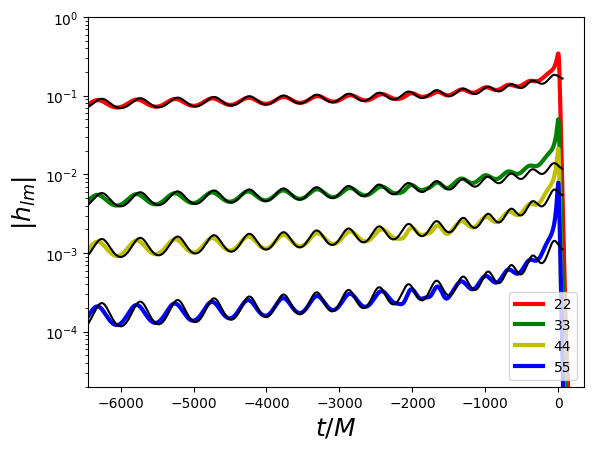

In [22]:
M0=40
M_SI=M0 * MSUN_SI
D_SI=(10**(6)) * PC_SI * 1

mode2polfac=(5/(64*np.pi))**(1/2)


plt.ylim(ymax=1e0)
plt.ylim(ymin=2e-5)
plt.xlim(xmin=-6450)
plt.xlim(xmax=350)
plt.ylabel(r'$|h_{lm}|$',size=18)
plt.xlabel(r'$t/M$',size=18)
plt.yscale('log')

plt.plot(thyb2/(M0*MTSUN_SI),abs(h22)/(G_SI*M_SI/D_SI/C_SI/C_SI),'r',linewidth=3,label='22')
plt.plot(thyb3/(M0*MTSUN_SI),abs(h33)/(G_SI*M_SI/D_SI/C_SI/C_SI),'g',linewidth=3,label='33')
plt.plot(thyb4/(M0*MTSUN_SI),abs(h44)/(G_SI*M_SI/D_SI/C_SI/C_SI),'y',linewidth=3,label='44')
plt.plot(thyb5/(M0*MTSUN_SI),abs(h55)/(G_SI*M_SI/D_SI/C_SI/C_SI),'b',linewidth=3,label='55')


plt.plot(time2/(40*MTSUN_SI),abs(hp2+1j*hc2)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')
plt.plot(time3/(40*MTSUN_SI),abs(hp3+1j*hc3)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')
plt.plot(time4/(40*MTSUN_SI),abs(hp4+1j*hc4)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')
plt.plot(time5/(40*MTSUN_SI),abs(hp5+1j*hc5)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')
plt.legend(loc='best')
plt.savefig("PN-hybrid comparison.pdf",dpi=300)



In [113]:
e=np.arange(0.08,0.082,0.00005)
#print(e)
for i in tqdm(e):
    kwargs = {
        "approximant": "EccentricTD",
        "q":2,
        "ecc":i,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": -0.181,
        "Momega0": 0.045**(3/2),
        "physicalUnits":True,
        "M":40,
        "D":1,
        "include_zero_ecc":True
        }
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict = load_waveform(origin, **kwargs)
    Time_data1 = dataDict["t"]
    return_dict1 = measure_eccentricity(tref_in = Time_data1, method =method, dataDict=dataDict)
    gwecc_object = return_dict1["gwecc_object"]
    Time_data = gwecc_object.get_omega22_average()[0]
    return_dict = measure_eccentricity(tref_in = Time_data, method =method, dataDict=dataDict)
    Ecc = return_dict["eccentricity"]
    Ecc_intrp = interp1d(Time_data, Ecc, kind='cubic',fill_value='extrapolate')
    Ecc = Ecc_intrp(Time_data1)
    if abs(Ecc[0]-0.12)<0.0005:
        print(i,Ecc[0]-0.12)



 32%|█████████████▋                             | 13/41 [01:04<02:21,  5.07s/it]

0.08059999999999994 -0.0004936408996581987


 34%|██████████████▋                            | 14/41 [01:09<02:14,  4.99s/it]

0.08064999999999993 -0.0004879188537597612


 37%|███████████████▋                           | 15/41 [01:13<02:06,  4.86s/it]

0.08069999999999992 -0.00037872314453124556


 39%|████████████████▊                          | 16/41 [01:18<01:59,  4.77s/it]

0.08074999999999992 -0.00023710250854491743


 41%|█████████████████▊                         | 17/41 [01:23<01:53,  4.71s/it]

0.08079999999999991 -0.00018035888671874556


 44%|██████████████████▉                        | 18/41 [01:27<01:47,  4.67s/it]

0.08084999999999991 -0.00010215759277343306


 46%|███████████████████▉                       | 19/41 [01:32<01:42,  4.64s/it]

0.0808999999999999 -2.014160156249556e-05


 49%|████████████████████▉                      | 20/41 [01:36<01:37,  4.63s/it]

0.0809499999999999 6.473541259766069e-05


 51%|██████████████████████                     | 21/41 [01:41<01:32,  4.62s/it]

0.08099999999999989 0.00014961242675781694


 54%|███████████████████████                    | 22/41 [01:45<01:27,  4.61s/it]

0.08104999999999989 0.0001772689819335982


 56%|████████████████████████                   | 23/41 [01:50<01:23,  4.62s/it]

0.08109999999999988 0.00024736404418945757


 59%|█████████████████████████▏                 | 24/41 [01:55<01:18,  4.63s/it]

0.08114999999999988 0.00029314041137695757


 61%|██████████████████████████▏                | 25/41 [01:59<01:14,  4.63s/it]

0.08119999999999987 0.00039947509765625444


 63%|███████████████████████████▎               | 26/41 [02:04<01:09,  4.63s/it]

0.08124999999999986 0.00048578262329102007


 66%|████████████████████████████▎              | 27/41 [02:09<01:06,  4.75s/it]

0.08129999999999986 0.0004786300659179732


 71%|██████████████████████████████▍            | 29/41 [02:22<00:58,  4.92s/it]


KeyboardInterrupt: 

In [117]:
kwargs = {
        "approximant": "EccentricTD",
        "q":2,
        "ecc":0.081,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": -0.181,
        "Momega0": 0.045**(3/2),
        "physicalUnits":True,
        "M":40,
        "D":1,
        "include_zero_ecc":True
        }
method = "ResidualAmplitude"
origin = "LAL"
dataDict = load_waveform(origin, **kwargs)
Time_data1 = dataDict["t"]
return_dict1 = measure_eccentricity(tref_in = Time_data1, method =method, dataDict=dataDict)
gwecc_object = return_dict1["gwecc_object"]
Time_data = gwecc_object.get_omega22_average()[0]
return_dict = measure_eccentricity(tref_in = Time_data, method =method, dataDict=dataDict)
Ecc = return_dict["eccentricity"]
Ecc_intrp = interp1d(Time_data, Ecc, kind='cubic',fill_value='extrapolate')
Ecc = Ecc_intrp(Time_data1)
print(Ecc[0])

0.12009525299072266


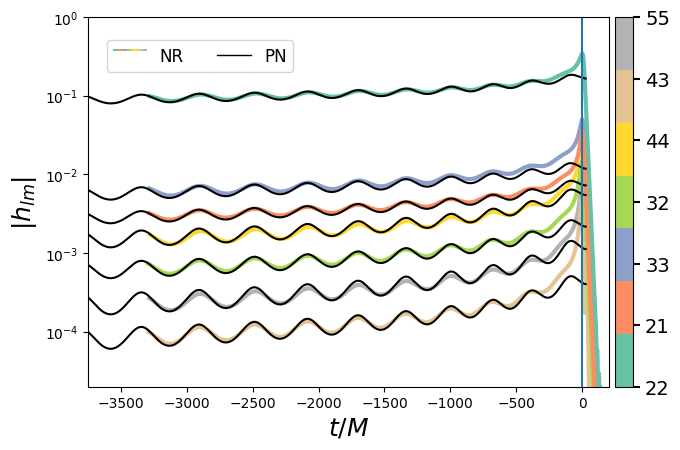

In [52]:
plt.figure(figsize=(8,4.8))
N = 7
cmap = plt.get_cmap('Set2', N)
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)

cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, N),pad=0.01)
#cbar.set_label(label='mode',size=20)
cbar.set_ticklabels(["22","21","33","32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=0)




import numpy as np
a55=np.loadtxt('PN55.txt')[:,0]
b55=np.loadtxt('PN55.txt')[:,1]
c55=np.loadtxt('NR55.txt')[:,0]
d55=np.loadtxt('NR55.txt')[:,1]
a43=np.loadtxt('PN43.txt')[:,0]
b43=np.loadtxt('PN43.txt')[:,1]
c43=np.loadtxt('NR43.txt')[:,0]
d43=np.loadtxt('NR43.txt')[:,1]
a44=np.loadtxt('PN44.txt')[:,0]
b44=np.loadtxt('PN44.txt')[:,1]
c44=np.loadtxt('NR44.txt')[:,0]
d44=np.loadtxt('NR44.txt')[:,1]
a32=np.loadtxt('PN32.txt')[:,0]
b32=np.loadtxt('PN32.txt')[:,1]
c32=np.loadtxt('NR32.txt')[:,0]
d32=np.loadtxt('NR32.txt')[:,1]
a33=np.loadtxt('PN33.txt')[:,0]
b33=np.loadtxt('PN33.txt')[:,1]
c33=np.loadtxt('NR33.txt')[:,0]
d33=np.loadtxt('NR33.txt')[:,1]
a21=np.loadtxt('PN21.txt')[:,0]
b21=np.loadtxt('PN21.txt')[:,1]
c21=np.loadtxt('NR21.txt')[:,0]
d21=np.loadtxt('NR21.txt')[:,1]
a22=np.loadtxt('PN22.txt')[:,0]
b22=np.loadtxt('PN22.txt')[:,1]
c22=np.loadtxt('NR22.txt')[:,0]
d22=np.loadtxt('NR22.txt')[:,1]
import matplotlib.pyplot as plt





ind=np.where(d55==max(d55))[0][0]
plt.plot(c55-c55[np.where(d55==max(d55))[0][0]],d55,linewidth=3.0,c=cmap(6))
plt.plot(c44-c44[np.where(d44==max(d44))[0][0]],d44,c=cmap(4),linewidth=3.0)
plt.plot(c43-c43[np.where(d43==max(d43))[0][0]],d43,c=cmap(5),linewidth=3.0)
plt.plot(c33-c33[np.where(d33==max(d33))[0][0]],d33,c=cmap(2),linewidth=3.0)
plt.plot(c32-c32[np.where(d32==max(d32))[0][0]],d32,c=cmap(3),linewidth=3.0)
plt.plot(c22-c22[np.where(d22==max(d22))[0][0]],d22,c=cmap(0),linewidth=3.0)
plt.plot(c21-c21[np.where(d21==max(d21))[0][0]],d21,c=cmap(1),linewidth=3.0)


plt.plot(time22/(40*MTSUN_SI)-32,abs(hp22+1j*hc22)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')
plt.plot(time21/(40*MTSUN_SI)-32,abs(hp21+1j*hc21)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')
plt.plot(time32/(40*MTSUN_SI)-32,abs(hp32+1j*hc32)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')
plt.plot(time43/(40*MTSUN_SI)-32,abs(hp43+1j*hc43)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')
plt.plot(time33/(40*MTSUN_SI)-32,abs(hp33+1j*hc33)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')
plt.plot(time4/(40*MTSUN_SI)-32,abs(hp4+1j*hc4)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')
plt.plot(time55/(40*MTSUN_SI)-32,abs(hp55+1j*hc55)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')

plt.axvline(x=0)




plt.ylim(ymax=1e0)
#plt.ylim(ymin=3e-6)
plt.ylim(ymin=2e-5)
plt.xlim(xmin=-3750)
plt.xlim(xmax=200)
plt.ylabel(r'$|h_{lm}|$',size=18)
plt.xlabel(r'$t/M$',size=18)
plt.yscale('log')


plt.minorticks_off()
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase
class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent+7], 
                          width / self.num_stripes, 
                          height/4.5, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes

x_array = np.linspace(10000, 10001, 1)
y_array = x_array
param_max = x_array.size
cmaps = [plt.get_cmap('Set2', 7)]#[plt.cm.Set2]  # set of colormaps 
                                        # (as many as there are groups of lines)

for param, (x, y) in enumerate(zip(x_array, y_array)):  
    x_line1 = np.linspace(x, 1.5 * x, 10)
    y_line1 = np.linspace(y**2, y**2 - x, 10)
    x_line2 = np.linspace(x, 1.5 * x, 10)
    y_line2 = np.linspace(y**2, y**2 - x, 10)

    # plot lines with color depending on param using different colormaps:
    plt.plot(x_line1, y_line1, c=cmaps[0](param / param_max))
    plt.plot(x_line2, y_line2)


lgd = Line2D([0], [0], color='black', lw=1)   
    
cmap_labels = ["NR","PN"]
cmap_handles = [Rectangle((0, 0), 1, 1)]
cmap_handles.append(lgd)
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=7) for cm in cmaps]))
plt.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,bbox_to_anchor=(0.02,0.96),prop={'size': 12}, ncol = 2, loc=2)




plt.savefig('Update_PN-NRCOMP.png',dpi=600)
plt.show()